# DataCoLab Task Assignment

## Step 1: Data Preprocessing and EDA

In [ ]:
# Import libraries
import re
import json
import string
from tqdm import tqdm
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from nltk.corpus import stopwords

In [ ]:
# CONSTANTS
UNKNOWN_GENRE = ('Unknown',)
UNKNOWN_AUTHOR = 'Unknown'

### Load dataset

In [ ]:
# header for dataset
header = ['Wikipedia article ID', 'Freebase ID', 'Book title', 'Author',
          'Publication date', 'Book genres (Freebase ID:name tuples)',
          'Plot summary']

# Load dataset from text file
data = pd.read_csv('booksummaries.txt', sep='\t', header=None,
                   names=header, encoding='utf-8')

In [ ]:
# Display sample of data
data.head()

,Wikipedia article ID,Freebase ID,Book title,Author,Publication date,Book genres (Freebase ID:name tuples),Plot summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [ ]:
# Display shape of data
print(f"Shape of dataset: {data.shape}")

Shape of dataset: (16559, 7)


### Preprocess Section

In [ ]:
# # Drop "Freebase ID" column cause that values are unique and useless
data = data.drop("Wikipedia article ID", axis=1)
data = data.drop("Freebase ID", axis=1)

# Add "Index" column by reset it
data = data.reset_index()
data.rename(columns={'index': 'Index'}, inplace=True)

In [ ]:
# convert all genres values into tuple
for i in tqdm(range(len(data))):
    try:
        genres_dict = json.loads(
            data.loc[i, 'Book genres (Freebase ID:name tuples)'])
        if isinstance(genres_dict, dict):
            data.at[i, 'Book genres (Freebase ID:name tuples)'] = tuple(
                genres_dict.values())
        else:
            data.at[i, 'Book genres (Freebase ID:name tuples)'] = np.nan
    # Handle NaN values and JSON decoding errors
    except (TypeError, json.JSONDecodeError):
        continue

data.rename(columns={'Book genres (Freebase ID:name tuples)': 'Book genres'},
            inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 16559/16559 [00:01<00:00, 12220.91it/s]


In [ ]:
def extract_year(pub_date):
    """
    Convert publication date to just the year
    (if it's in YYYY-MM-DD format)
    """
    if isinstance(pub_date, str) and '-' in pub_date:
        return pd.to_datetime(pub_date, errors='coerce').year
    return int(pub_date) if isinstance(pub_date, str) and pub_date.isdigit()\
        else np.nan

data['Publication year'] = data['Publication date'].apply(extract_year)

In [ ]:
# Remove duplicate rows
# Check for duplicates based on a unique identifier or key columns
duplicates = data.duplicated(subset=['Book title', 'Author'], keep='first')
print(f"Number of duplicate rows: {duplicates.sum()}")

# # Drop duplicates
data = data.drop_duplicates(subset=['Book title', 'Author'], keep='first')

Number of duplicate rows: 8


In [ ]:
# text cleaning
# if get an error for this line, you must use `nltk.download()`
# command and download stopwords
# stop_words = set(stopwords.words('english'))


def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stop words
    # we don't remove stop words to get more accurate text in step 2
    # text = ' '.join([word for word in text.split()
    #                  if word not in stop_words])
    # Remove extra  before and after whitespace

    text = text.strip()
    # check if text is none
    text = text if text else np.nan

    return text


data['Cleaned Summary'] = data['Plot summary'].apply(clean_text)

In [ ]:
# Drop rows where 'Cleaned Summary' is NaN
data = data.dropna(subset=['Cleaned Summary'])

In [ ]:
# summary length
data['Summary Length'] = data['Cleaned Summary']\
    .apply(lambda x: len(x.split()))

# Detect outliers in Summary_Length
Q1 = data['Summary Length'].quantile(0.25)
Q3 = data['Summary Length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Summary Length'] < lower_bound) |
                (data['Summary Length'] > upper_bound)]
print(f"Number of outliers in Summary Length: {outliers.shape[0]}")

# Remove outliers
data = data[(data['Summary Length'] >= lower_bound) &
            (data['Summary Length'] <= upper_bound)]

Number of outliers in Summary Length: 953


In [ ]:
# Fill Author missing values with UNKNOWN_AUTHOR variable because
# We cannot put anyone's book under the name of another author
data['Author'].fillna(UNKNOWN_AUTHOR, inplace=True)

In [ ]:
# Fill missing values book generes based of other author's book
# this section of code is not good and fix just 2 rows:)))


def fill_missing_genres(df, num_modes):
    for author, group in tqdm(df.groupby('Author')):
        if author != UNKNOWN_AUTHOR:
            genres = [genre for genres in group['Book genres'] if
                      isinstance(genres, tuple) for genre in genres]
            if genres:
                mode_genres = [genre for genre, _ in Counter(genres)
                               .most_common(num_modes)]
                # We do this because normally can't assign tuple
                # and we get an error
                if len(df.loc[(df['Author'] == author) &
                       (df['Book genres'].isnull()), 'Book genres']) > 0:
                    for i in data.loc[(data['Author'] == 'Aaron Allston') &
                                      (data['Book genres'].isnull()),
                                      'Index'].values:
                        df.at[i, 'Book genres'] = tuple(mode_genres)

    return df


# Fill missing genres based on author with the 5 most common genres
data = fill_missing_genres(data, 5)

100%|██████████████████████████████████████████████████████████████████████████████████████| 4553/4553 [00:13<00:00, 334.23it/s]


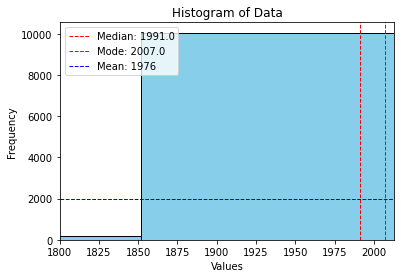

In [ ]:
# Plot a histogram to find out median is better for 'Publication year' or mode
median = data['Publication year'].median()
mode = data['Publication year'].mode()[0]
mean = int(data['Publication year'].mean())

plt.hist(data['Publication year'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Add markers for median and mode
plt.axvline(median, color='r', linestyle='dashed',
            linewidth=1, label=f'Median: {median}')
plt.axvline(mode, color='g', linestyle='dashed',
            linewidth=1, label=f'Mode: {mode}')
plt.axhline(mean, color='b', linestyle='dashed',
            linewidth=1, label=f'Mean: {mean}')
plt.xlim(1800, data['Publication year'].max())

plt.legend()
plt.show()

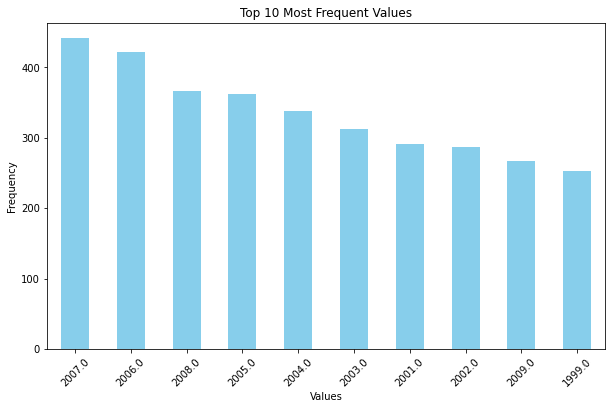

In [ ]:
# Calculate the frequency of each value
value_counts = data['Publication year'].value_counts()

# Get the top 10 most frequent values
top_values = value_counts.head(10)

# Plot a bar plot for the top 10 most frequent values
plt.figure(figsize=(10, 6))
top_values.plot(kind='bar', color='skyblue')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Values')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# fill Publication Year and Publication date missing value
# with mode of data based on Top 10 values plot
mean_year = int(data['Publication year'].mode()[0])
data['Publication year'].fillna(mean_year, inplace=True)
data['Publication date'].fillna(mean_year, inplace=True)

In [ ]:
# We can use "Title-Based" method or Pre-Trained NLP Model
# for Genre Prediction but in this step ignore this method
# and just set this missing value genre with UNKNOWN_GENRE variable


def fill_with_unknown_genre(x):
    return UNKNOWN_GENRE if pd.isnull(x) else x


data['Book genres'] = data['Book genres'].apply(fill_with_unknown_genre)

In [ ]:
# Check the Nan value of all columns
print(data.isna().sum())

Index               0
Book title          0
Author              0
Publication date    0
Book genres         0
Plot summary        0
Publication year    0
Cleaned Summary     0
Summary Length      0
dtype: int64


In [ ]:
# save cleaned data
data.to_csv('cleaned_book_summary.csv', sep='\t',
            index=False, encoding='utf-8')

### EDA section

In [ ]:
import ast
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load dataset from csv file
data = pd.read_csv('cleaned_book_summary.csv', sep='\t', encoding='utf-8')

In [ ]:
# convert all genres values into tuple
for i in tqdm(range(len(data))):
    try:
        genres_tuple = ast.literal_eval(data.loc[i, 'Book genres'])
        if isinstance(genres_tuple, tuple):
            data.at[i, 'Book genres'] = genres_tuple
        else:
            data.at[i, 'Book genres'] = np.nan
    except (SyntaxError, ValueError):
        continue

100%|███████████████████████████████████████████████████████████████████████████████████| 15593/15593 [00:01<00:00, 9633.51it/s]


In [ ]:
def get_genres_distribution(df):
    """
    Calculate the distribution of book genres in the provided DataFrame.

    Parameters:
    df (pandas.DataFrame): A DataFrame containing a column 'Book genres'
    with lists of genres for each book.

    Returns:
    pandas.Series: A Series object containing the count of each genre across
    all books in descending order.

    The function iterates through the 'Book genres' column of the DataFrame
    and counts the occurrences of each genre.
    It then sorts the genres_counts dictionary by the count of each genre in
    descending order. The sorted dictionary is converted into a Pandas Series
    and returned.
    """
    genres_counts = dict()
    for i, genres in enumerate(df['Book genres']):
        for genre in genres:
            genres_counts[genre] = genres_counts.get(genre, 0) + 1

    # Sort the genres_counts dictionary by values in descending order
    sorted_genres_counts = dict(sorted(genres_counts.items(),
                                       key=lambda item: item[1],
                                       reverse=True))

    # Convert the sorted dictionary to a Pandas Series
    genre_series = pd.Series(sorted_genres_counts)

    return genre_series

In [ ]:
# Get basic information about data
print(f"Number of books: {data.shape[0]}")
# Check for any remaining missing values
print(f"Missing values: {data.isnull().sum().any()}")

Number of books: 15593
Missing values: False



Summary length statistics:
count    15593.000000
mean       184.366575
std        155.291544
min          1.000000
25%         63.000000
50%        130.000000
75%        268.000000
max        668.000000
Name: Summary Length, dtype: float64


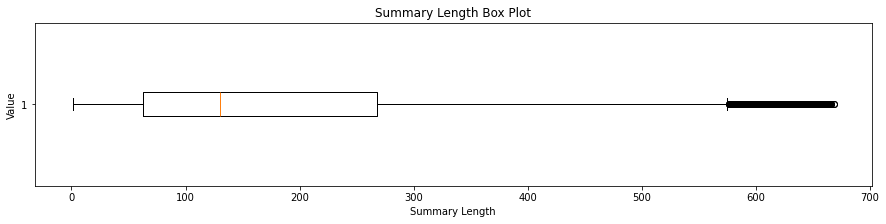

In [ ]:
# Analyze summary length
summary_stats = data['Summary Length'].describe()
print(f"\nSummary length statistics:\n{summary_stats}")

# box plot for summary length
plt.figure(figsize=(15, 3))
# Creating the box plot
plt.boxplot(data['Summary Length'], vert=False)
plt.title('Summary Length Box Plot')
plt.xlabel('Summary Length')
plt.ylabel('Value')
plt.show()


Publication year statistics:
count    15593.000000
mean      1986.779581
std         42.171144
min        398.000000
25%       1982.000000
50%       2004.000000
75%       2007.000000
max       2013.000000
Name: Publication year, dtype: float64


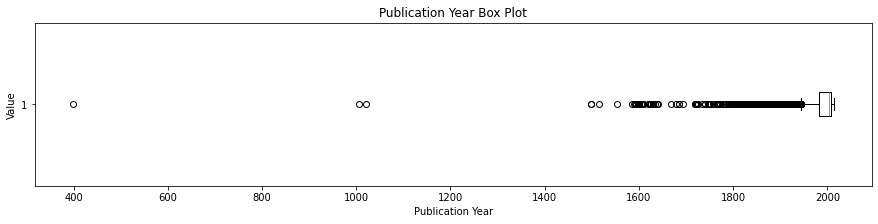

In [ ]:
# Analyze publication year
publication_stats = data['Publication year'].describe()
print(f"\nPublication year statistics:\n{publication_stats}")

# box plot for publication year
plt.figure(figsize=(15, 3))
# Creating the box plot
plt.boxplot(data['Publication year'], vert=False)
plt.title('Publication Year Box Plot')
plt.xlabel('Publication Year')
plt.ylabel('Value')
plt.show()


Genre distribution:
Fiction                4401
Speculative fiction    3995
Unknown                3552
Science Fiction        2675
Novel                  2312
                       ... 
Popular culture           1
Neuroscience              1
Alien invasion            1
Comedy of manners         1
Pastiche                  1
Length: 223, dtype: int64


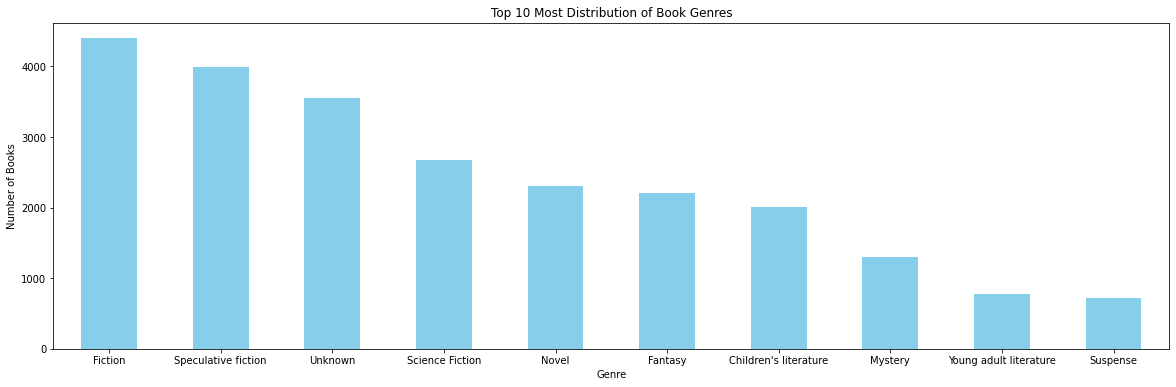

In [ ]:
# Genre distribution
genre_counts = get_genres_distribution(data)
print(f"\nGenre distribution:\n{genre_counts}")

# Get the top 10 most frequent genres
top_genres = genre_counts.head(10)

# Plot genre distribution
plt.figure(figsize=(20, 6))
top_genres.plot(kind='bar', color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Books')
plt.title('Top 10 Most Distribution of Book Genres')
plt.xticks(rotation=0)
plt.show()


Publication year distribution:

Publication year
2007.0    5756
2006.0     422
2008.0     366
2005.0     362
2004.0     338
          ... 
1590.0       1
1768.0       1
1621.0       1
1516.0       1
1640.0       1
Name: count, Length: 264, dtype: int64


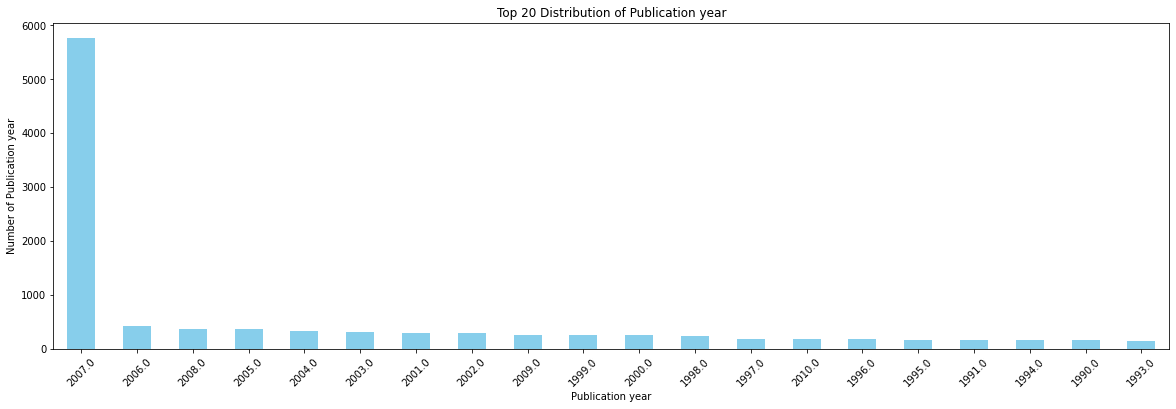

In [ ]:
# Publication year distribution
year_counts = data['Publication year'].value_counts()
print(f"\nPublication year distribution:\n\n{year_counts}")

# Get the top 20 most frequent publication year
top_years = year_counts.head(20)

# Plot publication year distribution
plt.figure(figsize=(20, 6))
top_years.plot(kind='bar', color='skyblue')
plt.xlabel("Publication year")
plt.ylabel("Number of Publication year")
plt.title("Top 20 Distribution of Publication year")
plt.xticks(rotation=45)
plt.show()


Author analysis:

Author
Unknown                 2294
Franklin W. Dixon         67
K. A. Applegate           60
Agatha Christie           58
Edgar Rice Burroughs      57
                        ... 
Mary Cheney                1
Nick Enright               1
Sion Sono                  1
Ntozake Shange             1
Stephen Colbert            1
Name: count, Length: 4553, dtype: int64


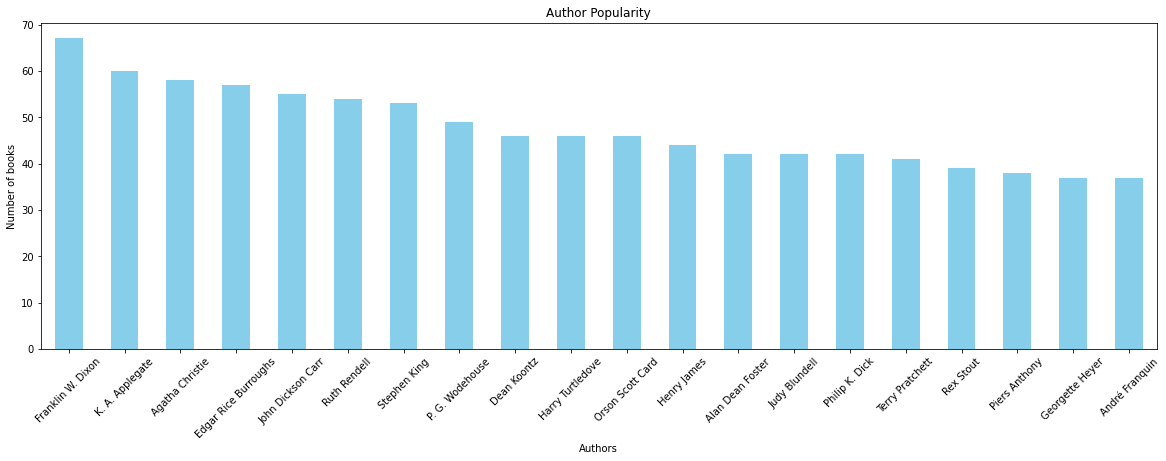

In [ ]:
# Author analysis
author_counts = data['Author'].value_counts()
print(f"\nAuthor analysis:\n\n{author_counts}")

# Get the top 20 most frequent authors
top_authors = author_counts.head(21)[1:]  # remove the Unknown author

# Plot most frequent authors
plt.figure(figsize=(20, 6))
top_authors.plot(kind='bar', color='skyblue')
plt.xlabel("Authors")
plt.ylabel("Number of books")
plt.title("Author Popularity")
plt.xticks(rotation=45)
plt.show()

(Science Fiction, Speculative fiction)    1860
(Speculative fiction, Fiction)            1829
(Speculative fiction, Fantasy)            1186
(Children's literature, Fiction)          1037
(Science Fiction, Fiction)                1001
(Fantasy, Fiction)                         941
(Mystery, Fiction)                         802
(Fiction, Novel)                           745
(Fiction, Suspense)                        620
(Mystery, Suspense)                        613
Name: count, dtype: int64


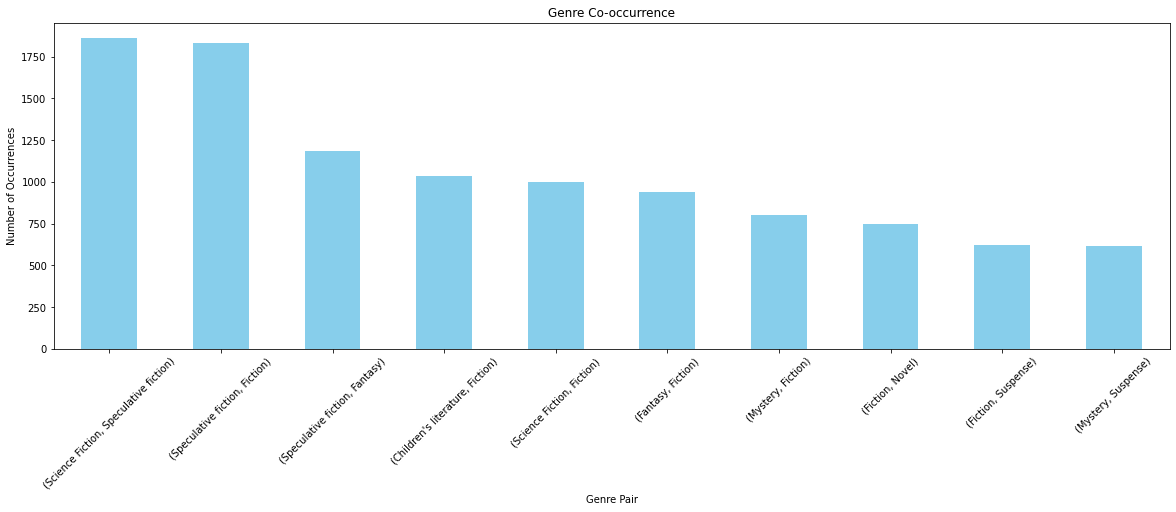

In [ ]:
# Genre Co-occurrence analysis
genre_pairs = []
for genres in data['Book genres']:
    for i in range(len(genres) - 1):
        for j in range(i + 1, len(genres)):
            pair = (genres[i], genres[j])
            genre_pairs.append(pair)

# Count occurrences
genre_pair_counts = pd.Series(genre_pairs).value_counts()

# Print top 10 most frequent genre pairs
most_frequent_genre_pairs = genre_pair_counts.head(10)
print(most_frequent_genre_pairs)

# Plot most frequent genre co-occurrence
plt.figure(figsize=(20, 6))
most_frequent_genre_pairs.plot(kind='bar', color='skyblue')
plt.xlabel("Genre Pair")
plt.ylabel("Number of Occurrences")
plt.title("Genre Co-occurrence")
plt.xticks(rotation=45)
plt.show()

## Step 2: NLP Component

In [1]:
# import google drive to use gpu for this section
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers torch rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=fd2f97638b1c2e60b403487996adba099755868c2eb6e0682b8ec8cd31f6e9e1
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from tqdm import tqdm
import pandas as pd
import torch
from transformers import BartTokenizer, BartForConditionalGeneration

In [ ]:
# Load pre-trained BART model and tokenizer, move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pre-trained BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn',
                                          clean_up_tokenization_spaces=True)
model = BartForConditionalGeneration.from_pretrained(
    'facebook/bart-large-cnn').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [ ]:
# Load dataset from csv file from drive for google colab
file_path = 'drive/MyDrive/cleaned_book_summary.csv'
data = pd.read_csv(file_path, sep='\t', encoding='utf-8')

In [ ]:
# # Load dataset from local csv file
# data = pd.read_csv('cleaned_book_summary.csv', sep='\t', encoding='utf-8')

In [ ]:
def summarize_batch(texts, max_input_length=1024, max_output_length=100, num_beams=2, device='cpu'):
    """
    Summarizes a batch of input texts using the BART model.

    Args:
    texts (list of str): List of original texts to be summarized.
    max_input_length (int): Maximum number of tokens in the input text.
    max_output_length (int): Maximum number of tokens in the summarized text.
    num_beams (int): Number of beams for beam search.
    device (str): Device to run the model on ('cpu' or 'cuda').

    Returns:
    list of str: List of summarized texts.
    """
    # Tokenize and truncate the input to the max input length (batch processing)
    inputs = tokenizer(texts, return_tensors="pt", max_length=max_input_length, truncation=True, padding=True).to(device)

    # Generate the summary for the batch
    summary_ids = model.generate(
        inputs["input_ids"],
        num_beams=num_beams,  # Beam search for diversity
        max_length=max_output_length,  # Limit the length of the output summary
        early_stopping=True  # Stop when the model is confident in its answer
    )

    # Decode the generated tokens into a string (summary)
    return [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in summary_ids]


In [ ]:
# Example usage on a single text summary
sample_text = data.loc[0, 'Cleaned Summary']
short_summary = summarize_batch([sample_text], device=device)[0]
print("Cleaned Summary lenght:", len(sample_text.split()))
print("Summarized Text lenght:", len(short_summary.split()))
print("Summarized Text:", short_summary)

Cleaned Summary lenght: 531
Summarized Text lenght: 72
Summarized Text: old major old boar manor farm calls animals farm meeting compares humans parasites teaches animals revolutionary song beasts england major dies two young pigs snowball napoleon assume command turn dream philosophy animals revolt drive drunken irresponsible mr jones farm renaming animal farm adopt seven commandments animalism important animals equal snowball attempts teach animals reading writing food plentiful farm runs smoothly pigs elevate positions leadership set aside special food items ostensibly personal health.


In [ ]:
# Check for accuracy of the model with sample text
from rouge_score import rouge_scorer

# Define the original text and summarized text
# we use sample_text as original_text and short_summary as summarized text

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Compute ROUGE scores
scores = scorer.score(sample_text, short_summary)

# Print ROUGE scores
print("ROUGE-1: ", scores['rouge1'])
print("ROUGE-2: ", scores['rouge2'])
print("ROUGE-L: ", scores['rougeL'])


ROUGE-1:  Score(precision=1.0, recall=0.13559322033898305, fmeasure=0.23880597014925373)
ROUGE-2:  Score(precision=1.0, recall=0.1339622641509434, fmeasure=0.2362728785357737)
ROUGE-L:  Score(precision=1.0, recall=0.13559322033898305, fmeasure=0.23880597014925373)


The ROUGE scores you've obtained provide valuable insight into the performance of your summarization model. Here's a breakdown of the results:

### **ROUGE-1:**
- **Precision = 1.0**: This indicates that 100% of the unigrams (individual words) in the summary are found in the original text. In other words, all the words in the summary are present in the original.
- **Recall = 0.136 (approx)**: Only about 13.6% of the unigrams from the original text are included in the summary, meaning the summary is quite condensed.
- **F1-Score = 0.239 (approx)**: This score represents the harmonic mean between precision and recall, balancing both metrics. While precision is perfect, the relatively low recall pulls the F1-score down.

### **ROUGE-2:**
- **Precision = 1.0**: All the bigrams (pairs of consecutive words) in the summary appear in the original text.
- **Recall = 0.134 (approx)**: Only about 13.4% of the bigrams from the original text are present in the summary, indicating that the bigram coverage of the original content is limited.
- **F1-Score = 0.236 (approx)**: This score reflects the balance between precision and recall for bigrams. Similar to ROUGE-1, the perfect precision is offset by low recall.

### **ROUGE-L:**
- **Precision = 1.0**: All of the longest common subsequences (chunks of text that maintain word order) in the summary are present in the original text.
- **Recall = 0.136 (approx)**: About 13.6% of the original text's sequences are included in the summary, again showing that the summary is highly condensed.
- **F1-Score = 0.239 (approx)**: This score balances precision and recall for subsequences, similar to the unigrams and bigrams.

### **Interpretation:**
- **Perfect precision (1.0)**: All of the words, bigrams, and sequences in the summary are taken directly from the original text. This means the summary is highly faithful to the original in terms of word choice and order.
- **Low recall (~13.5%)**: The summary only includes a small portion of the original text, indicating a significant reduction in content. This could be because the summary is intentionally short.
- **F1-scores (~0.239)**: The F1-scores reflect the balance between precision and recall. Since precision is perfect but recall is low, the F1-scores are relatively low.

### **Summary of Findings:**
- The summarization model generates summaries that are **very precise**, ensuring that the words and phrases used are accurately drawn from the original text.
- However, the **low recall** suggests that the summaries omit a large portion of the original content, making them very condensed.
- If your goal is to produce **short, concise summaries**, this level of condensation may be ideal. On the other hand, if you'd like to retain more of the original content, you may need to **increase the summary length** or adjust the model's parameters.

In [ ]:
def batch_summarization(df, batch_size=32, num_beams=2, device='cpu'):
    """
    Summarizes the text in batches to manage memory and computation, leveraging GPU and batching.

    Args:
    df (DataFrame): The input DataFrame containing the 'Cleaned Summary' column.
    batch_size (int): Number of rows to process in each batch.
    num_beams (int): Number of beams for beam search.
    device (str): Device to run the model on ('cpu' or 'cuda').

    Returns:
    DataFrame: The DataFrame with a new column 'Summarized_Text'.
    """
    # Ensure the new column exists
    df['Summarized_Text'] = ""

    for i in tqdm(range(0, len(df), batch_size)):
        batch_df = df.iloc[i:i+batch_size]
        texts = batch_df['Cleaned Summary'].tolist()  # Extract the batch of texts
        summaries = summarize_batch(texts, num_beams=num_beams, device=device)  # Summarize the batch
        df.loc[batch_df.index, 'Summarized_Text'] = summaries  # Update the DataFrame with the summarized text

        print(f"Processed batch {i} to {i+batch_size}")

    return df

In [ ]:
# Summarize the text in batches
data = batch_summarization(data, batch_size=32, num_beams=2, device=device)

  0%|          | 1/488 [00:16<2:10:14, 16.05s/it]

Processed batch 0 to 32



  0%|          | 2/488 [00:30<2:01:38, 15.02s/it]

Processed batch 32 to 64



  1%|          | 3/488 [00:46<2:04:15, 15.37s/it]

Processed batch 64 to 96



  1%|          | 4/488 [01:02<2:06:46, 15.72s/it]

Processed batch 96 to 128



  1%|          | 5/488 [01:16<2:02:52, 15.26s/it]

Processed batch 128 to 160



  1%|          | 6/488 [01:30<1:57:46, 14.66s/it]

Processed batch 160 to 192



  1%|▏         | 7/488 [01:46<2:00:39, 15.05s/it]

Processed batch 192 to 224



  2%|▏         | 8/488 [02:00<1:59:33, 14.95s/it]

Processed batch 224 to 256



  2%|▏         | 9/488 [02:14<1:55:38, 14.48s/it]

Processed batch 256 to 288



  2%|▏         | 10/488 [02:29<1:56:18, 14.60s/it]

Processed batch 288 to 320



  2%|▏         | 11/488 [02:43<1:56:23, 14.64s/it]

Processed batch 320 to 352



  2%|▏         | 12/488 [02:57<1:53:10, 14.26s/it]

Processed batch 352 to 384



  3%|▎         | 13/488 [03:12<1:53:58, 14.40s/it]

Processed batch 384 to 416



  3%|▎         | 14/488 [03:23<1:47:30, 13.61s/it]

Processed batch 416 to 448



  3%|▎         | 15/488 [03:37<1:48:16, 13.74s/it]

Processed batch 448 to 480



  3%|▎         | 16/488 [03:53<1:51:35, 14.19s/it]

Processed batch 480 to 512



  3%|▎         | 17/488 [04:07<1:52:31, 14.33s/it]

Processed batch 512 to 544



  4%|▎         | 18/488 [04:22<1:53:33, 14.50s/it]

Processed batch 544 to 576



  4%|▍         | 19/488 [04:35<1:50:11, 14.10s/it]

Processed batch 576 to 608



  4%|▍         | 20/488 [04:49<1:48:59, 13.97s/it]

Processed batch 608 to 640



  4%|▍         | 21/488 [05:04<1:51:03, 14.27s/it]

Processed batch 640 to 672



  5%|▍         | 22/488 [05:18<1:49:05, 14.05s/it]

Processed batch 672 to 704



  5%|▍         | 23/488 [05:33<1:51:11, 14.35s/it]

Processed batch 704 to 736



  5%|▍         | 24/488 [05:46<1:49:55, 14.21s/it]

Processed batch 736 to 768



  5%|▌         | 25/488 [06:01<1:51:24, 14.44s/it]

Processed batch 768 to 800



  5%|▌         | 26/488 [06:15<1:48:31, 14.09s/it]

Processed batch 800 to 832



  6%|▌         | 27/488 [06:29<1:47:39, 14.01s/it]

Processed batch 832 to 864



  6%|▌         | 28/488 [06:42<1:46:34, 13.90s/it]

Processed batch 864 to 896



  6%|▌         | 29/488 [06:56<1:46:58, 13.98s/it]

Processed batch 896 to 928



  6%|▌         | 30/488 [07:11<1:47:20, 14.06s/it]

Processed batch 928 to 960



  6%|▋         | 31/488 [07:25<1:46:43, 14.01s/it]

Processed batch 960 to 992



  7%|▋         | 32/488 [07:39<1:47:22, 14.13s/it]

Processed batch 992 to 1024



  7%|▋         | 33/488 [07:54<1:48:52, 14.36s/it]

Processed batch 1024 to 1056



  7%|▋         | 34/488 [08:06<1:42:38, 13.56s/it]

Processed batch 1056 to 1088



  7%|▋         | 35/488 [08:21<1:47:48, 14.28s/it]

Processed batch 1088 to 1120



  7%|▋         | 36/488 [08:36<1:48:56, 14.46s/it]

Processed batch 1120 to 1152



  8%|▊         | 37/488 [08:51<1:49:38, 14.59s/it]

Processed batch 1152 to 1184



  8%|▊         | 38/488 [09:07<1:51:14, 14.83s/it]

Processed batch 1184 to 1216



  8%|▊         | 39/488 [09:20<1:47:13, 14.33s/it]

Processed batch 1216 to 1248



  8%|▊         | 40/488 [09:33<1:45:10, 14.09s/it]

Processed batch 1248 to 1280



  8%|▊         | 41/488 [09:47<1:44:49, 14.07s/it]

Processed batch 1280 to 1312



  9%|▊         | 42/488 [10:01<1:43:33, 13.93s/it]

Processed batch 1312 to 1344



  9%|▉         | 43/488 [10:13<1:39:20, 13.40s/it]

Processed batch 1344 to 1376



  9%|▉         | 44/488 [10:25<1:35:18, 12.88s/it]

Processed batch 1376 to 1408



  9%|▉         | 45/488 [10:38<1:34:55, 12.86s/it]

Processed batch 1408 to 1440



  9%|▉         | 46/488 [10:52<1:37:29, 13.23s/it]

Processed batch 1440 to 1472



 10%|▉         | 47/488 [11:06<1:39:32, 13.54s/it]

Processed batch 1472 to 1504



 10%|▉         | 48/488 [11:20<1:40:02, 13.64s/it]

Processed batch 1504 to 1536



 10%|█         | 49/488 [11:36<1:44:34, 14.29s/it]

Processed batch 1536 to 1568



 10%|█         | 50/488 [11:49<1:42:42, 14.07s/it]

Processed batch 1568 to 1600



 10%|█         | 51/488 [12:03<1:42:42, 14.10s/it]

Processed batch 1600 to 1632



 11%|█         | 52/488 [12:15<1:38:03, 13.49s/it]

Processed batch 1632 to 1664



 11%|█         | 53/488 [12:30<1:39:27, 13.72s/it]

Processed batch 1664 to 1696



 11%|█         | 54/488 [12:44<1:40:29, 13.89s/it]

Processed batch 1696 to 1728



 11%|█▏        | 55/488 [12:57<1:38:46, 13.69s/it]

Processed batch 1728 to 1760



 11%|█▏        | 56/488 [13:11<1:39:49, 13.87s/it]

Processed batch 1760 to 1792



 12%|█▏        | 57/488 [13:24<1:36:44, 13.47s/it]

Processed batch 1792 to 1824



 12%|█▏        | 58/488 [13:39<1:39:20, 13.86s/it]

Processed batch 1824 to 1856



 12%|█▏        | 59/488 [13:53<1:39:59, 13.98s/it]

Processed batch 1856 to 1888



 12%|█▏        | 60/488 [14:04<1:33:52, 13.16s/it]

Processed batch 1888 to 1920



 12%|█▎        | 61/488 [14:18<1:34:29, 13.28s/it]

Processed batch 1920 to 1952



 13%|█▎        | 62/488 [14:31<1:34:22, 13.29s/it]

Processed batch 1952 to 1984



 13%|█▎        | 63/488 [14:44<1:32:53, 13.11s/it]

Processed batch 1984 to 2016



 13%|█▎        | 64/488 [14:58<1:34:59, 13.44s/it]

Processed batch 2016 to 2048



 13%|█▎        | 65/488 [15:13<1:38:49, 14.02s/it]

Processed batch 2048 to 2080



 14%|█▎        | 66/488 [15:26<1:34:49, 13.48s/it]

Processed batch 2080 to 2112



 14%|█▎        | 67/488 [15:40<1:36:45, 13.79s/it]

Processed batch 2112 to 2144



 14%|█▍        | 68/488 [15:55<1:39:30, 14.22s/it]

Processed batch 2144 to 2176



 14%|█▍        | 69/488 [16:08<1:36:25, 13.81s/it]

Processed batch 2176 to 2208



 14%|█▍        | 70/488 [16:23<1:38:54, 14.20s/it]

Processed batch 2208 to 2240



 15%|█▍        | 71/488 [16:37<1:38:23, 14.16s/it]

Processed batch 2240 to 2272



 15%|█▍        | 72/488 [16:49<1:32:06, 13.28s/it]

Processed batch 2272 to 2304



 15%|█▍        | 73/488 [17:03<1:33:48, 13.56s/it]

Processed batch 2304 to 2336



 15%|█▌        | 74/488 [17:14<1:29:07, 12.92s/it]

Processed batch 2336 to 2368



 15%|█▌        | 75/488 [17:28<1:29:43, 13.04s/it]

Processed batch 2368 to 2400



 16%|█▌        | 76/488 [17:41<1:31:19, 13.30s/it]

Processed batch 2400 to 2432



 16%|█▌        | 77/488 [17:55<1:32:22, 13.49s/it]

Processed batch 2432 to 2464



 16%|█▌        | 78/488 [18:09<1:32:02, 13.47s/it]

Processed batch 2464 to 2496



 16%|█▌        | 79/488 [18:25<1:36:50, 14.21s/it]

Processed batch 2496 to 2528



 16%|█▋        | 80/488 [18:40<1:38:25, 14.47s/it]

Processed batch 2528 to 2560



 17%|█▋        | 81/488 [18:51<1:31:28, 13.48s/it]

Processed batch 2560 to 2592



 17%|█▋        | 82/488 [19:06<1:34:40, 13.99s/it]

Processed batch 2592 to 2624



 17%|█▋        | 83/488 [19:18<1:28:59, 13.18s/it]

Processed batch 2624 to 2656



 17%|█▋        | 84/488 [19:30<1:27:19, 12.97s/it]

Processed batch 2656 to 2688



 17%|█▋        | 85/488 [19:43<1:26:36, 12.89s/it]

Processed batch 2688 to 2720



 18%|█▊        | 86/488 [19:55<1:24:23, 12.60s/it]

Processed batch 2720 to 2752



 18%|█▊        | 87/488 [20:07<1:23:51, 12.55s/it]

Processed batch 2752 to 2784



 18%|█▊        | 88/488 [20:20<1:24:49, 12.72s/it]

Processed batch 2784 to 2816



 18%|█▊        | 89/488 [20:34<1:27:07, 13.10s/it]

Processed batch 2816 to 2848



 18%|█▊        | 90/488 [20:46<1:24:08, 12.69s/it]

Processed batch 2848 to 2880



 19%|█▊        | 91/488 [21:00<1:25:55, 12.99s/it]

Processed batch 2880 to 2912



 19%|█▉        | 92/488 [21:07<1:15:41, 11.47s/it]

Processed batch 2912 to 2944



 19%|█▉        | 93/488 [21:18<1:14:22, 11.30s/it]

Processed batch 2944 to 2976



 19%|█▉        | 94/488 [21:30<1:15:08, 11.44s/it]

Processed batch 2976 to 3008



 19%|█▉        | 95/488 [21:43<1:18:32, 11.99s/it]

Processed batch 3008 to 3040



 20%|█▉        | 96/488 [21:57<1:20:50, 12.37s/it]

Processed batch 3040 to 3072



 20%|█▉        | 97/488 [22:10<1:23:04, 12.75s/it]

Processed batch 3072 to 3104



 20%|██        | 98/488 [22:24<1:23:58, 12.92s/it]

Processed batch 3104 to 3136



 20%|██        | 99/488 [22:38<1:27:19, 13.47s/it]

Processed batch 3136 to 3168



 20%|██        | 100/488 [22:51<1:24:58, 13.14s/it]

Processed batch 3168 to 3200



 21%|██        | 101/488 [23:06<1:27:54, 13.63s/it]

Processed batch 3200 to 3232



 21%|██        | 102/488 [23:19<1:27:45, 13.64s/it]

Processed batch 3232 to 3264



 21%|██        | 103/488 [23:34<1:28:49, 13.84s/it]

Processed batch 3264 to 3296



 21%|██▏       | 104/488 [23:44<1:22:58, 12.97s/it]

Processed batch 3296 to 3328



 22%|██▏       | 105/488 [23:57<1:22:08, 12.87s/it]

Processed batch 3328 to 3360



 22%|██▏       | 106/488 [24:11<1:23:18, 13.09s/it]

Processed batch 3360 to 3392



 22%|██▏       | 107/488 [24:21<1:18:00, 12.28s/it]

Processed batch 3392 to 3424



 22%|██▏       | 108/488 [24:35<1:20:50, 12.76s/it]

Processed batch 3424 to 3456



 22%|██▏       | 109/488 [24:49<1:23:21, 13.20s/it]

Processed batch 3456 to 3488



 23%|██▎       | 110/488 [25:04<1:26:22, 13.71s/it]

Processed batch 3488 to 3520



 23%|██▎       | 111/488 [25:17<1:25:06, 13.55s/it]

Processed batch 3520 to 3552



 23%|██▎       | 112/488 [25:28<1:18:51, 12.58s/it]

Processed batch 3552 to 3584



 23%|██▎       | 113/488 [25:39<1:17:13, 12.36s/it]

Processed batch 3584 to 3616



 23%|██▎       | 114/488 [25:54<1:21:59, 13.15s/it]

Processed batch 3616 to 3648



 24%|██▎       | 115/488 [26:08<1:23:28, 13.43s/it]

Processed batch 3648 to 3680



 24%|██▍       | 116/488 [26:22<1:24:12, 13.58s/it]

Processed batch 3680 to 3712



 24%|██▍       | 117/488 [26:36<1:23:33, 13.51s/it]

Processed batch 3712 to 3744



 24%|██▍       | 118/488 [26:49<1:23:07, 13.48s/it]

Processed batch 3744 to 3776



 24%|██▍       | 119/488 [27:02<1:22:04, 13.35s/it]

Processed batch 3776 to 3808



 25%|██▍       | 120/488 [27:14<1:18:04, 12.73s/it]

Processed batch 3808 to 3840



 25%|██▍       | 121/488 [27:30<1:23:58, 13.73s/it]

Processed batch 3840 to 3872



 25%|██▌       | 122/488 [27:41<1:20:18, 13.17s/it]

Processed batch 3872 to 3904



 25%|██▌       | 123/488 [27:54<1:18:48, 12.96s/it]

Processed batch 3904 to 3936



 25%|██▌       | 124/488 [28:07<1:19:39, 13.13s/it]

Processed batch 3936 to 3968



 26%|██▌       | 125/488 [28:23<1:23:02, 13.73s/it]

Processed batch 3968 to 4000



 26%|██▌       | 126/488 [28:37<1:23:25, 13.83s/it]

Processed batch 4000 to 4032



 26%|██▌       | 127/488 [28:51<1:24:58, 14.12s/it]

Processed batch 4032 to 4064



 26%|██▌       | 128/488 [29:04<1:21:56, 13.66s/it]

Processed batch 4064 to 4096



 26%|██▋       | 129/488 [29:18<1:21:57, 13.70s/it]

Processed batch 4096 to 4128



 27%|██▋       | 130/488 [29:32<1:22:33, 13.84s/it]

Processed batch 4128 to 4160



 27%|██▋       | 131/488 [29:46<1:22:22, 13.84s/it]

Processed batch 4160 to 4192



 27%|██▋       | 132/488 [29:59<1:20:54, 13.63s/it]

Processed batch 4192 to 4224



 27%|██▋       | 133/488 [30:13<1:20:50, 13.66s/it]

Processed batch 4224 to 4256



 27%|██▋       | 134/488 [30:26<1:20:20, 13.62s/it]

Processed batch 4256 to 4288



 28%|██▊       | 135/488 [30:41<1:21:19, 13.82s/it]

Processed batch 4288 to 4320



 28%|██▊       | 136/488 [30:53<1:18:01, 13.30s/it]

Processed batch 4320 to 4352



 28%|██▊       | 137/488 [31:05<1:16:11, 13.02s/it]

Processed batch 4352 to 4384



 28%|██▊       | 138/488 [31:14<1:08:52, 11.81s/it]

Processed batch 4384 to 4416



 28%|██▊       | 139/488 [31:27<1:11:00, 12.21s/it]

Processed batch 4416 to 4448



 29%|██▊       | 140/488 [31:40<1:11:37, 12.35s/it]

Processed batch 4448 to 4480



 29%|██▉       | 141/488 [31:52<1:10:42, 12.23s/it]

Processed batch 4480 to 4512



 29%|██▉       | 142/488 [32:05<1:12:20, 12.55s/it]

Processed batch 4512 to 4544



 29%|██▉       | 143/488 [32:16<1:09:56, 12.16s/it]

Processed batch 4544 to 4576



 30%|██▉       | 144/488 [32:29<1:10:12, 12.25s/it]

Processed batch 4576 to 4608



 30%|██▉       | 145/488 [32:42<1:11:43, 12.55s/it]

Processed batch 4608 to 4640



 30%|██▉       | 146/488 [32:58<1:17:01, 13.51s/it]

Processed batch 4640 to 4672



 30%|███       | 147/488 [33:12<1:17:52, 13.70s/it]

Processed batch 4672 to 4704



 30%|███       | 148/488 [33:23<1:13:31, 12.97s/it]

Processed batch 4704 to 4736



 31%|███       | 149/488 [33:35<1:12:16, 12.79s/it]

Processed batch 4736 to 4768



 31%|███       | 150/488 [33:47<1:10:21, 12.49s/it]

Processed batch 4768 to 4800



 31%|███       | 151/488 [33:59<1:08:03, 12.12s/it]

Processed batch 4800 to 4832



 31%|███       | 152/488 [34:12<1:09:22, 12.39s/it]

Processed batch 4832 to 4864



 31%|███▏      | 153/488 [34:26<1:12:05, 12.91s/it]

Processed batch 4864 to 4896



 32%|███▏      | 154/488 [34:38<1:11:19, 12.81s/it]

Processed batch 4896 to 4928



 32%|███▏      | 155/488 [34:52<1:13:04, 13.17s/it]

Processed batch 4928 to 4960



 32%|███▏      | 156/488 [35:03<1:09:18, 12.53s/it]

Processed batch 4960 to 4992



 32%|███▏      | 157/488 [35:17<1:10:19, 12.75s/it]

Processed batch 4992 to 5024



 32%|███▏      | 158/488 [35:29<1:08:57, 12.54s/it]

Processed batch 5024 to 5056



 33%|███▎      | 159/488 [35:43<1:11:29, 13.04s/it]

Processed batch 5056 to 5088



 33%|███▎      | 160/488 [35:53<1:06:05, 12.09s/it]

Processed batch 5088 to 5120



 33%|███▎      | 161/488 [36:05<1:05:48, 12.08s/it]

Processed batch 5120 to 5152



 33%|███▎      | 162/488 [36:17<1:06:02, 12.16s/it]

Processed batch 5152 to 5184



 33%|███▎      | 163/488 [36:29<1:06:14, 12.23s/it]

Processed batch 5184 to 5216



 34%|███▎      | 164/488 [36:43<1:07:58, 12.59s/it]

Processed batch 5216 to 5248



 34%|███▍      | 165/488 [36:57<1:09:38, 12.94s/it]

Processed batch 5248 to 5280



 34%|███▍      | 166/488 [37:11<1:11:19, 13.29s/it]

Processed batch 5280 to 5312



 34%|███▍      | 167/488 [37:22<1:07:14, 12.57s/it]

Processed batch 5312 to 5344



 34%|███▍      | 168/488 [37:35<1:08:56, 12.93s/it]

Processed batch 5344 to 5376



 35%|███▍      | 169/488 [37:47<1:06:54, 12.58s/it]

Processed batch 5376 to 5408



 35%|███▍      | 170/488 [38:01<1:08:03, 12.84s/it]

Processed batch 5408 to 5440



 35%|███▌      | 171/488 [38:15<1:10:47, 13.40s/it]

Processed batch 5440 to 5472



 35%|███▌      | 172/488 [38:25<1:05:14, 12.39s/it]

Processed batch 5472 to 5504



 35%|███▌      | 173/488 [38:37<1:04:04, 12.20s/it]

Processed batch 5504 to 5536



 36%|███▌      | 174/488 [38:49<1:03:54, 12.21s/it]

Processed batch 5536 to 5568



 36%|███▌      | 175/488 [39:02<1:03:35, 12.19s/it]

Processed batch 5568 to 5600



 36%|███▌      | 176/488 [39:15<1:05:00, 12.50s/it]

Processed batch 5600 to 5632



 36%|███▋      | 177/488 [39:28<1:06:09, 12.76s/it]

Processed batch 5632 to 5664



 36%|███▋      | 178/488 [39:41<1:05:42, 12.72s/it]

Processed batch 5664 to 5696



 37%|███▋      | 179/488 [39:53<1:05:34, 12.73s/it]

Processed batch 5696 to 5728



 37%|███▋      | 180/488 [40:04<1:02:27, 12.17s/it]

Processed batch 5728 to 5760



 37%|███▋      | 181/488 [40:16<1:00:56, 11.91s/it]

Processed batch 5760 to 5792



 37%|███▋      | 182/488 [40:25<57:32, 11.28s/it]  

Processed batch 5792 to 5824



 38%|███▊      | 183/488 [40:40<1:02:41, 12.33s/it]

Processed batch 5824 to 5856



 38%|███▊      | 184/488 [40:53<1:02:36, 12.36s/it]

Processed batch 5856 to 5888



 38%|███▊      | 185/488 [41:03<59:25, 11.77s/it]  

Processed batch 5888 to 5920



 38%|███▊      | 186/488 [41:16<1:00:25, 12.00s/it]

Processed batch 5920 to 5952



 38%|███▊      | 187/488 [41:29<1:01:57, 12.35s/it]

Processed batch 5952 to 5984



 39%|███▊      | 188/488 [41:41<1:00:50, 12.17s/it]

Processed batch 5984 to 6016



 39%|███▊      | 189/488 [41:54<1:03:04, 12.66s/it]

Processed batch 6016 to 6048



 39%|███▉      | 190/488 [42:09<1:05:49, 13.25s/it]

Processed batch 6048 to 6080



 39%|███▉      | 191/488 [42:19<1:01:28, 12.42s/it]

Processed batch 6080 to 6112



 39%|███▉      | 192/488 [42:34<1:04:20, 13.04s/it]

Processed batch 6112 to 6144



 40%|███▉      | 193/488 [42:47<1:04:20, 13.08s/it]

Processed batch 6144 to 6176



 40%|███▉      | 194/488 [42:58<1:01:05, 12.47s/it]

Processed batch 6176 to 6208



 40%|███▉      | 195/488 [43:11<1:01:38, 12.62s/it]

Processed batch 6208 to 6240



 40%|████      | 196/488 [43:24<1:02:15, 12.79s/it]

Processed batch 6240 to 6272



 40%|████      | 197/488 [43:36<1:00:17, 12.43s/it]

Processed batch 6272 to 6304



 41%|████      | 198/488 [43:49<1:00:58, 12.61s/it]

Processed batch 6304 to 6336



 41%|████      | 199/488 [44:03<1:02:20, 12.94s/it]

Processed batch 6336 to 6368



 41%|████      | 200/488 [44:13<57:46, 12.03s/it]  

Processed batch 6368 to 6400



 41%|████      | 201/488 [44:25<57:31, 12.03s/it]

Processed batch 6400 to 6432



 41%|████▏     | 202/488 [44:38<58:55, 12.36s/it]

Processed batch 6432 to 6464



 42%|████▏     | 203/488 [44:53<1:02:26, 13.15s/it]

Processed batch 6464 to 6496



 42%|████▏     | 204/488 [45:07<1:04:11, 13.56s/it]

Processed batch 6496 to 6528



 42%|████▏     | 205/488 [45:19<1:01:35, 13.06s/it]

Processed batch 6528 to 6560



 42%|████▏     | 206/488 [45:30<58:22, 12.42s/it]  

Processed batch 6560 to 6592



 42%|████▏     | 207/488 [45:44<1:00:05, 12.83s/it]

Processed batch 6592 to 6624



 43%|████▎     | 208/488 [45:56<59:12, 12.69s/it]  

Processed batch 6624 to 6656



 43%|████▎     | 209/488 [46:11<1:02:19, 13.40s/it]

Processed batch 6656 to 6688



 43%|████▎     | 210/488 [46:25<1:03:15, 13.65s/it]

Processed batch 6688 to 6720



 43%|████▎     | 211/488 [46:39<1:03:10, 13.69s/it]

Processed batch 6720 to 6752



 43%|████▎     | 212/488 [46:54<1:04:22, 14.00s/it]

Processed batch 6752 to 6784



 44%|████▎     | 213/488 [47:04<59:16, 12.93s/it]  

Processed batch 6784 to 6816



 44%|████▍     | 214/488 [47:19<1:01:30, 13.47s/it]

Processed batch 6816 to 6848



 44%|████▍     | 215/488 [47:33<1:01:52, 13.60s/it]

Processed batch 6848 to 6880



 44%|████▍     | 216/488 [47:47<1:02:39, 13.82s/it]

Processed batch 6880 to 6912



 44%|████▍     | 217/488 [48:03<1:04:42, 14.33s/it]

Processed batch 6912 to 6944



 45%|████▍     | 218/488 [48:16<1:03:11, 14.04s/it]

Processed batch 6944 to 6976



 45%|████▍     | 219/488 [48:31<1:03:23, 14.14s/it]

Processed batch 6976 to 7008



 45%|████▌     | 220/488 [48:45<1:02:47, 14.06s/it]

Processed batch 7008 to 7040



 45%|████▌     | 221/488 [48:58<1:01:20, 13.79s/it]

Processed batch 7040 to 7072



 45%|████▌     | 222/488 [49:13<1:02:41, 14.14s/it]

Processed batch 7072 to 7104



 46%|████▌     | 223/488 [49:25<59:35, 13.49s/it]  

Processed batch 7104 to 7136



 46%|████▌     | 224/488 [49:40<1:02:29, 14.20s/it]

Processed batch 7136 to 7168



 46%|████▌     | 225/488 [49:52<59:22, 13.55s/it]  

Processed batch 7168 to 7200



 46%|████▋     | 226/488 [50:06<58:39, 13.43s/it]

Processed batch 7200 to 7232



 47%|████▋     | 227/488 [50:20<59:22, 13.65s/it]

Processed batch 7232 to 7264



 47%|████▋     | 228/488 [50:33<58:27, 13.49s/it]

Processed batch 7264 to 7296



 47%|████▋     | 229/488 [50:48<59:43, 13.84s/it]

Processed batch 7296 to 7328



 47%|████▋     | 230/488 [51:02<59:59, 13.95s/it]

Processed batch 7328 to 7360



 47%|████▋     | 231/488 [51:14<57:34, 13.44s/it]

Processed batch 7360 to 7392



 48%|████▊     | 232/488 [51:25<54:05, 12.68s/it]

Processed batch 7392 to 7424



 48%|████▊     | 233/488 [51:37<52:57, 12.46s/it]

Processed batch 7424 to 7456



 48%|████▊     | 234/488 [51:49<52:32, 12.41s/it]

Processed batch 7456 to 7488



 48%|████▊     | 235/488 [52:03<54:18, 12.88s/it]

Processed batch 7488 to 7520



 48%|████▊     | 236/488 [52:17<55:51, 13.30s/it]

Processed batch 7520 to 7552



 49%|████▊     | 237/488 [52:30<54:44, 13.09s/it]

Processed batch 7552 to 7584



 49%|████▉     | 238/488 [52:39<49:41, 11.93s/it]

Processed batch 7584 to 7616



 49%|████▉     | 239/488 [52:52<50:04, 12.07s/it]

Processed batch 7616 to 7648



 49%|████▉     | 240/488 [53:05<51:10, 12.38s/it]

Processed batch 7648 to 7680



 49%|████▉     | 241/488 [53:18<51:35, 12.53s/it]

Processed batch 7680 to 7712



 50%|████▉     | 242/488 [53:31<52:02, 12.69s/it]

Processed batch 7712 to 7744



 50%|████▉     | 243/488 [53:42<49:56, 12.23s/it]

Processed batch 7744 to 7776



 50%|█████     | 244/488 [53:55<50:43, 12.47s/it]

Processed batch 7776 to 7808



 50%|█████     | 245/488 [54:07<49:42, 12.27s/it]

Processed batch 7808 to 7840



 50%|█████     | 246/488 [54:21<51:24, 12.74s/it]

Processed batch 7840 to 7872



 51%|█████     | 247/488 [54:33<51:20, 12.78s/it]

Processed batch 7872 to 7904



 51%|█████     | 248/488 [54:47<52:39, 13.17s/it]

Processed batch 7904 to 7936



 51%|█████     | 249/488 [55:02<54:31, 13.69s/it]

Processed batch 7936 to 7968



 51%|█████     | 250/488 [55:16<54:08, 13.65s/it]

Processed batch 7968 to 8000



 51%|█████▏    | 251/488 [55:29<53:27, 13.54s/it]

Processed batch 8000 to 8032



 52%|█████▏    | 252/488 [55:43<54:04, 13.75s/it]

Processed batch 8032 to 8064



 52%|█████▏    | 253/488 [55:57<53:30, 13.66s/it]

Processed batch 8064 to 8096



 52%|█████▏    | 254/488 [56:09<51:06, 13.10s/it]

Processed batch 8096 to 8128



 52%|█████▏    | 255/488 [56:22<50:54, 13.11s/it]

Processed batch 8128 to 8160



 52%|█████▏    | 256/488 [56:36<51:51, 13.41s/it]

Processed batch 8160 to 8192



 53%|█████▎    | 257/488 [56:48<50:19, 13.07s/it]

Processed batch 8192 to 8224



 53%|█████▎    | 258/488 [57:02<50:28, 13.17s/it]

Processed batch 8224 to 8256



 53%|█████▎    | 259/488 [57:15<50:13, 13.16s/it]

Processed batch 8256 to 8288



 53%|█████▎    | 260/488 [57:25<46:08, 12.14s/it]

Processed batch 8288 to 8320



 53%|█████▎    | 261/488 [57:36<45:00, 11.90s/it]

Processed batch 8320 to 8352



 54%|█████▎    | 262/488 [57:48<44:51, 11.91s/it]

Processed batch 8352 to 8384



 54%|█████▍    | 263/488 [58:01<46:11, 12.32s/it]

Processed batch 8384 to 8416



 54%|█████▍    | 264/488 [58:14<46:52, 12.56s/it]

Processed batch 8416 to 8448



 54%|█████▍    | 265/488 [58:27<46:34, 12.53s/it]

Processed batch 8448 to 8480



 55%|█████▍    | 266/488 [58:40<47:36, 12.87s/it]

Processed batch 8480 to 8512



 55%|█████▍    | 267/488 [58:52<46:32, 12.63s/it]

Processed batch 8512 to 8544



 55%|█████▍    | 268/488 [59:07<48:01, 13.10s/it]

Processed batch 8544 to 8576



 55%|█████▌    | 269/488 [59:21<49:09, 13.47s/it]

Processed batch 8576 to 8608



 55%|█████▌    | 270/488 [59:35<49:18, 13.57s/it]

Processed batch 8608 to 8640



 56%|█████▌    | 271/488 [59:45<45:49, 12.67s/it]

Processed batch 8640 to 8672



 56%|█████▌    | 272/488 [59:58<45:09, 12.54s/it]

Processed batch 8672 to 8704



 56%|█████▌    | 273/488 [1:00:08<43:00, 12.00s/it]

Processed batch 8704 to 8736



 56%|█████▌    | 274/488 [1:00:21<43:37, 12.23s/it]

Processed batch 8736 to 8768



 56%|█████▋    | 275/488 [1:00:34<44:28, 12.53s/it]

Processed batch 8768 to 8800



 57%|█████▋    | 276/488 [1:00:47<44:44, 12.66s/it]

Processed batch 8800 to 8832



 57%|█████▋    | 277/488 [1:01:01<45:17, 12.88s/it]

Processed batch 8832 to 8864



 57%|█████▋    | 278/488 [1:01:16<48:03, 13.73s/it]

Processed batch 8864 to 8896



 57%|█████▋    | 279/488 [1:01:32<49:27, 14.20s/it]

Processed batch 8896 to 8928



 57%|█████▋    | 280/488 [1:01:45<48:12, 13.91s/it]

Processed batch 8928 to 8960



 58%|█████▊    | 281/488 [1:01:56<45:03, 13.06s/it]

Processed batch 8960 to 8992



 58%|█████▊    | 282/488 [1:02:08<43:21, 12.63s/it]

Processed batch 8992 to 9024



 58%|█████▊    | 283/488 [1:02:21<43:56, 12.86s/it]

Processed batch 9024 to 9056



 58%|█████▊    | 284/488 [1:02:34<44:10, 12.99s/it]

Processed batch 9056 to 9088



 58%|█████▊    | 285/488 [1:02:45<41:39, 12.31s/it]

Processed batch 9088 to 9120



 59%|█████▊    | 286/488 [1:02:58<41:37, 12.37s/it]

Processed batch 9120 to 9152



 59%|█████▉    | 287/488 [1:03:09<40:38, 12.13s/it]

Processed batch 9152 to 9184



 59%|█████▉    | 288/488 [1:03:24<42:54, 12.87s/it]

Processed batch 9184 to 9216



 59%|█████▉    | 289/488 [1:03:39<44:45, 13.49s/it]

Processed batch 9216 to 9248



 59%|█████▉    | 290/488 [1:03:51<43:26, 13.16s/it]

Processed batch 9248 to 9280



 60%|█████▉    | 291/488 [1:04:03<42:32, 12.96s/it]

Processed batch 9280 to 9312



 60%|█████▉    | 292/488 [1:04:19<44:23, 13.59s/it]

Processed batch 9312 to 9344



 60%|██████    | 293/488 [1:04:33<45:17, 13.94s/it]

Processed batch 9344 to 9376



 60%|██████    | 294/488 [1:04:45<42:58, 13.29s/it]

Processed batch 9376 to 9408



 60%|██████    | 295/488 [1:04:59<43:28, 13.51s/it]

Processed batch 9408 to 9440



 61%|██████    | 296/488 [1:05:11<41:39, 13.02s/it]

Processed batch 9440 to 9472



 61%|██████    | 297/488 [1:05:25<41:58, 13.19s/it]

Processed batch 9472 to 9504



 61%|██████    | 298/488 [1:05:37<41:08, 12.99s/it]

Processed batch 9504 to 9536



 61%|██████▏   | 299/488 [1:05:50<41:15, 13.10s/it]

Processed batch 9536 to 9568



 61%|██████▏   | 300/488 [1:06:01<39:05, 12.47s/it]

Processed batch 9568 to 9600



 62%|██████▏   | 301/488 [1:06:15<39:24, 12.64s/it]

Processed batch 9600 to 9632



 62%|██████▏   | 302/488 [1:06:26<38:32, 12.43s/it]

Processed batch 9632 to 9664



 62%|██████▏   | 303/488 [1:06:39<38:10, 12.38s/it]

Processed batch 9664 to 9696



 62%|██████▏   | 304/488 [1:06:51<38:06, 12.43s/it]

Processed batch 9696 to 9728



 62%|██████▎   | 305/488 [1:07:06<39:56, 13.09s/it]

Processed batch 9728 to 9760



 63%|██████▎   | 306/488 [1:07:20<40:53, 13.48s/it]

Processed batch 9760 to 9792



 63%|██████▎   | 307/488 [1:07:34<40:34, 13.45s/it]

Processed batch 9792 to 9824



 63%|██████▎   | 308/488 [1:07:46<39:42, 13.24s/it]

Processed batch 9824 to 9856



 63%|██████▎   | 309/488 [1:08:00<40:12, 13.48s/it]

Processed batch 9856 to 9888



 64%|██████▎   | 310/488 [1:08:15<40:34, 13.68s/it]

Processed batch 9888 to 9920



 64%|██████▎   | 311/488 [1:08:27<39:06, 13.25s/it]

Processed batch 9920 to 9952



 64%|██████▍   | 312/488 [1:08:38<37:26, 12.76s/it]

Processed batch 9952 to 9984



 64%|██████▍   | 313/488 [1:08:49<35:34, 12.19s/it]

Processed batch 9984 to 10016



 64%|██████▍   | 314/488 [1:09:02<35:23, 12.21s/it]

Processed batch 10016 to 10048



 65%|██████▍   | 315/488 [1:09:16<37:08, 12.88s/it]

Processed batch 10048 to 10080



 65%|██████▍   | 316/488 [1:09:28<36:27, 12.72s/it]

Processed batch 10080 to 10112



 65%|██████▍   | 317/488 [1:09:41<35:58, 12.62s/it]

Processed batch 10112 to 10144



 65%|██████▌   | 318/488 [1:09:53<35:50, 12.65s/it]

Processed batch 10144 to 10176



 65%|██████▌   | 319/488 [1:10:08<37:36, 13.35s/it]

Processed batch 10176 to 10208



 66%|██████▌   | 320/488 [1:10:22<37:14, 13.30s/it]

Processed batch 10208 to 10240



 66%|██████▌   | 321/488 [1:10:34<36:38, 13.16s/it]

Processed batch 10240 to 10272



 66%|██████▌   | 322/488 [1:10:48<36:27, 13.18s/it]

Processed batch 10272 to 10304



 66%|██████▌   | 323/488 [1:11:02<37:34, 13.66s/it]

Processed batch 10304 to 10336



 66%|██████▋   | 324/488 [1:11:14<35:37, 13.03s/it]

Processed batch 10336 to 10368



 67%|██████▋   | 325/488 [1:11:24<33:07, 12.19s/it]

Processed batch 10368 to 10400



 67%|██████▋   | 326/488 [1:11:36<32:29, 12.03s/it]

Processed batch 10400 to 10432



 67%|██████▋   | 327/488 [1:11:50<33:40, 12.55s/it]

Processed batch 10432 to 10464



 67%|██████▋   | 328/488 [1:12:04<34:41, 13.01s/it]

Processed batch 10464 to 10496



 67%|██████▋   | 329/488 [1:12:16<34:11, 12.90s/it]

Processed batch 10496 to 10528



 68%|██████▊   | 330/488 [1:12:30<34:23, 13.06s/it]

Processed batch 10528 to 10560



 68%|██████▊   | 331/488 [1:12:43<33:55, 12.96s/it]

Processed batch 10560 to 10592



 68%|██████▊   | 332/488 [1:12:54<32:44, 12.59s/it]

Processed batch 10592 to 10624



 68%|██████▊   | 333/488 [1:13:08<33:42, 13.05s/it]

Processed batch 10624 to 10656



 68%|██████▊   | 334/488 [1:13:18<31:03, 12.10s/it]

Processed batch 10656 to 10688



 69%|██████▊   | 335/488 [1:13:31<31:17, 12.27s/it]

Processed batch 10688 to 10720



 69%|██████▉   | 336/488 [1:13:43<30:55, 12.21s/it]

Processed batch 10720 to 10752



 69%|██████▉   | 337/488 [1:13:57<32:09, 12.78s/it]

Processed batch 10752 to 10784



 69%|██████▉   | 338/488 [1:14:06<28:41, 11.47s/it]

Processed batch 10784 to 10816



 69%|██████▉   | 339/488 [1:14:20<30:31, 12.30s/it]

Processed batch 10816 to 10848



 70%|██████▉   | 340/488 [1:14:34<32:05, 13.01s/it]

Processed batch 10848 to 10880



 70%|██████▉   | 341/488 [1:14:49<33:04, 13.50s/it]

Processed batch 10880 to 10912



 70%|███████   | 342/488 [1:15:02<32:09, 13.21s/it]

Processed batch 10912 to 10944



 70%|███████   | 343/488 [1:15:13<30:17, 12.54s/it]

Processed batch 10944 to 10976



 70%|███████   | 344/488 [1:15:23<28:38, 11.93s/it]

Processed batch 10976 to 11008



 71%|███████   | 345/488 [1:15:34<27:43, 11.64s/it]

Processed batch 11008 to 11040



 71%|███████   | 346/488 [1:15:47<28:46, 12.16s/it]

Processed batch 11040 to 11072



 71%|███████   | 347/488 [1:16:00<29:09, 12.40s/it]

Processed batch 11072 to 11104



 71%|███████▏  | 348/488 [1:16:12<28:18, 12.13s/it]

Processed batch 11104 to 11136



 72%|███████▏  | 349/488 [1:16:27<30:16, 13.07s/it]

Processed batch 11136 to 11168



 72%|███████▏  | 350/488 [1:16:42<31:03, 13.50s/it]

Processed batch 11168 to 11200



 72%|███████▏  | 351/488 [1:16:55<30:28, 13.34s/it]

Processed batch 11200 to 11232



 72%|███████▏  | 352/488 [1:17:04<27:32, 12.15s/it]

Processed batch 11232 to 11264



 72%|███████▏  | 353/488 [1:17:16<27:07, 12.05s/it]

Processed batch 11264 to 11296



 73%|███████▎  | 354/488 [1:17:30<28:16, 12.66s/it]

Processed batch 11296 to 11328



 73%|███████▎  | 355/488 [1:17:42<27:43, 12.51s/it]

Processed batch 11328 to 11360



 73%|███████▎  | 356/488 [1:17:55<27:52, 12.67s/it]

Processed batch 11360 to 11392



 73%|███████▎  | 357/488 [1:18:07<26:55, 12.33s/it]

Processed batch 11392 to 11424



 73%|███████▎  | 358/488 [1:18:19<26:44, 12.34s/it]

Processed batch 11424 to 11456



 74%|███████▎  | 359/488 [1:18:32<26:49, 12.48s/it]

Processed batch 11456 to 11488



 74%|███████▍  | 360/488 [1:18:44<26:06, 12.23s/it]

Processed batch 11488 to 11520



 74%|███████▍  | 361/488 [1:18:57<26:55, 12.72s/it]

Processed batch 11520 to 11552



 74%|███████▍  | 362/488 [1:19:11<27:04, 12.89s/it]

Processed batch 11552 to 11584



 74%|███████▍  | 363/488 [1:19:22<26:10, 12.56s/it]

Processed batch 11584 to 11616



 75%|███████▍  | 364/488 [1:19:35<25:53, 12.53s/it]

Processed batch 11616 to 11648



 75%|███████▍  | 365/488 [1:19:48<26:14, 12.80s/it]

Processed batch 11648 to 11680



 75%|███████▌  | 366/488 [1:20:00<25:36, 12.60s/it]

Processed batch 11680 to 11712



 75%|███████▌  | 367/488 [1:20:14<25:54, 12.85s/it]

Processed batch 11712 to 11744



 75%|███████▌  | 368/488 [1:20:27<26:02, 13.02s/it]

Processed batch 11744 to 11776



 76%|███████▌  | 369/488 [1:20:40<25:21, 12.79s/it]

Processed batch 11776 to 11808



 76%|███████▌  | 370/488 [1:20:50<23:59, 12.20s/it]

Processed batch 11808 to 11840



 76%|███████▌  | 371/488 [1:21:01<23:04, 11.83s/it]

Processed batch 11840 to 11872



 76%|███████▌  | 372/488 [1:21:11<21:49, 11.29s/it]

Processed batch 11872 to 11904



 76%|███████▋  | 373/488 [1:21:23<21:35, 11.26s/it]

Processed batch 11904 to 11936



 77%|███████▋  | 374/488 [1:21:36<22:51, 12.03s/it]

Processed batch 11936 to 11968



 77%|███████▋  | 375/488 [1:21:48<22:29, 11.95s/it]

Processed batch 11968 to 12000



 77%|███████▋  | 376/488 [1:21:59<21:54, 11.74s/it]

Processed batch 12000 to 12032



 77%|███████▋  | 377/488 [1:22:10<20:55, 11.31s/it]

Processed batch 12032 to 12064



 77%|███████▋  | 378/488 [1:22:24<22:16, 12.15s/it]

Processed batch 12064 to 12096



 78%|███████▊  | 379/488 [1:22:35<21:41, 11.94s/it]

Processed batch 12096 to 12128



 78%|███████▊  | 380/488 [1:22:45<20:32, 11.41s/it]

Processed batch 12128 to 12160



 78%|███████▊  | 381/488 [1:22:59<21:18, 11.95s/it]

Processed batch 12160 to 12192



 78%|███████▊  | 382/488 [1:23:13<22:30, 12.75s/it]

Processed batch 12192 to 12224



 78%|███████▊  | 383/488 [1:23:29<23:44, 13.57s/it]

Processed batch 12224 to 12256



 79%|███████▊  | 384/488 [1:23:39<21:38, 12.48s/it]

Processed batch 12256 to 12288



 79%|███████▉  | 385/488 [1:23:51<21:05, 12.28s/it]

Processed batch 12288 to 12320



 79%|███████▉  | 386/488 [1:24:02<20:13, 11.90s/it]

Processed batch 12320 to 12352



 79%|███████▉  | 387/488 [1:24:15<20:46, 12.34s/it]

Processed batch 12352 to 12384



 80%|███████▉  | 388/488 [1:24:26<19:49, 11.89s/it]

Processed batch 12384 to 12416



 80%|███████▉  | 389/488 [1:24:38<19:55, 12.08s/it]

Processed batch 12416 to 12448



 80%|███████▉  | 390/488 [1:24:51<19:57, 12.22s/it]

Processed batch 12448 to 12480



 80%|████████  | 391/488 [1:25:03<19:33, 12.10s/it]

Processed batch 12480 to 12512



 80%|████████  | 392/488 [1:25:17<20:35, 12.87s/it]

Processed batch 12512 to 12544



 81%|████████  | 393/488 [1:25:29<20:01, 12.64s/it]

Processed batch 12544 to 12576



 81%|████████  | 394/488 [1:25:41<19:21, 12.35s/it]

Processed batch 12576 to 12608



 81%|████████  | 395/488 [1:25:55<19:57, 12.88s/it]

Processed batch 12608 to 12640



 81%|████████  | 396/488 [1:26:09<20:12, 13.18s/it]

Processed batch 12640 to 12672



 81%|████████▏ | 397/488 [1:26:20<19:11, 12.65s/it]

Processed batch 12672 to 12704



 82%|████████▏ | 398/488 [1:26:32<18:34, 12.38s/it]

Processed batch 12704 to 12736



 82%|████████▏ | 399/488 [1:26:44<18:04, 12.19s/it]

Processed batch 12736 to 12768



 82%|████████▏ | 400/488 [1:26:57<18:21, 12.52s/it]

Processed batch 12768 to 12800



 82%|████████▏ | 401/488 [1:27:09<17:55, 12.36s/it]

Processed batch 12800 to 12832



 82%|████████▏ | 402/488 [1:27:19<16:47, 11.72s/it]

Processed batch 12832 to 12864



 83%|████████▎ | 403/488 [1:27:33<17:33, 12.40s/it]

Processed batch 12864 to 12896



 83%|████████▎ | 404/488 [1:27:46<17:25, 12.44s/it]

Processed batch 12896 to 12928



 83%|████████▎ | 405/488 [1:27:57<16:42, 12.08s/it]

Processed batch 12928 to 12960



 83%|████████▎ | 406/488 [1:28:12<17:35, 12.87s/it]

Processed batch 12960 to 12992



 83%|████████▎ | 407/488 [1:28:25<17:27, 12.94s/it]

Processed batch 12992 to 13024



 84%|████████▎ | 408/488 [1:28:40<18:13, 13.67s/it]

Processed batch 13024 to 13056



 84%|████████▍ | 409/488 [1:28:53<17:40, 13.42s/it]

Processed batch 13056 to 13088



 84%|████████▍ | 410/488 [1:29:06<17:10, 13.21s/it]

Processed batch 13088 to 13120



 84%|████████▍ | 411/488 [1:29:16<15:43, 12.25s/it]

Processed batch 13120 to 13152



 84%|████████▍ | 412/488 [1:29:30<16:03, 12.67s/it]

Processed batch 13152 to 13184



 85%|████████▍ | 413/488 [1:29:41<15:29, 12.39s/it]

Processed batch 13184 to 13216



 85%|████████▍ | 414/488 [1:29:55<15:39, 12.70s/it]

Processed batch 13216 to 13248



 85%|████████▌ | 415/488 [1:30:05<14:42, 12.09s/it]

Processed batch 13248 to 13280



 85%|████████▌ | 416/488 [1:30:17<14:23, 12.00s/it]

Processed batch 13280 to 13312



 85%|████████▌ | 417/488 [1:30:30<14:20, 12.13s/it]

Processed batch 13312 to 13344



 86%|████████▌ | 418/488 [1:30:41<13:53, 11.91s/it]

Processed batch 13344 to 13376



 86%|████████▌ | 419/488 [1:30:56<14:43, 12.80s/it]

Processed batch 13376 to 13408



 86%|████████▌ | 420/488 [1:31:08<14:24, 12.71s/it]

Processed batch 13408 to 13440



 86%|████████▋ | 421/488 [1:31:21<14:06, 12.64s/it]

Processed batch 13440 to 13472



 86%|████████▋ | 422/488 [1:31:34<14:06, 12.83s/it]

Processed batch 13472 to 13504



 87%|████████▋ | 423/488 [1:31:46<13:30, 12.48s/it]

Processed batch 13504 to 13536



 87%|████████▋ | 424/488 [1:32:00<13:59, 13.12s/it]

Processed batch 13536 to 13568



 87%|████████▋ | 425/488 [1:32:14<13:52, 13.22s/it]

Processed batch 13568 to 13600



 87%|████████▋ | 426/488 [1:32:25<12:58, 12.56s/it]

Processed batch 13600 to 13632



 88%|████████▊ | 427/488 [1:32:38<13:02, 12.82s/it]

Processed batch 13632 to 13664



 88%|████████▊ | 428/488 [1:32:53<13:23, 13.38s/it]

Processed batch 13664 to 13696



 88%|████████▊ | 429/488 [1:33:07<13:25, 13.66s/it]

Processed batch 13696 to 13728



 88%|████████▊ | 430/488 [1:33:20<13:00, 13.46s/it]

Processed batch 13728 to 13760



 88%|████████▊ | 431/488 [1:33:32<12:08, 12.78s/it]

Processed batch 13760 to 13792



 89%|████████▊ | 432/488 [1:33:45<12:09, 13.03s/it]

Processed batch 13792 to 13824



 89%|████████▊ | 433/488 [1:33:59<12:13, 13.34s/it]

Processed batch 13824 to 13856



 89%|████████▉ | 434/488 [1:34:10<11:19, 12.58s/it]

Processed batch 13856 to 13888



 89%|████████▉ | 435/488 [1:34:19<10:09, 11.50s/it]

Processed batch 13888 to 13920



 89%|████████▉ | 436/488 [1:34:31<10:06, 11.67s/it]

Processed batch 13920 to 13952



 90%|████████▉ | 437/488 [1:34:42<09:50, 11.58s/it]

Processed batch 13952 to 13984



 90%|████████▉ | 438/488 [1:34:55<09:54, 11.89s/it]

Processed batch 13984 to 14016



 90%|████████▉ | 439/488 [1:35:07<09:44, 11.94s/it]

Processed batch 14016 to 14048



 90%|█████████ | 440/488 [1:35:18<09:19, 11.66s/it]

Processed batch 14048 to 14080



 90%|█████████ | 441/488 [1:35:32<09:41, 12.38s/it]

Processed batch 14080 to 14112



 91%|█████████ | 442/488 [1:35:47<09:56, 12.96s/it]

Processed batch 14112 to 14144



 91%|█████████ | 443/488 [1:35:58<09:21, 12.48s/it]

Processed batch 14144 to 14176



 91%|█████████ | 444/488 [1:36:11<09:11, 12.53s/it]

Processed batch 14176 to 14208



 91%|█████████ | 445/488 [1:36:25<09:21, 13.06s/it]

Processed batch 14208 to 14240



 91%|█████████▏| 446/488 [1:36:39<09:21, 13.37s/it]

Processed batch 14240 to 14272



 92%|█████████▏| 447/488 [1:36:52<09:04, 13.28s/it]

Processed batch 14272 to 14304



 92%|█████████▏| 448/488 [1:37:01<08:00, 12.01s/it]

Processed batch 14304 to 14336



 92%|█████████▏| 449/488 [1:37:13<07:51, 12.09s/it]

Processed batch 14336 to 14368



 92%|█████████▏| 450/488 [1:37:26<07:50, 12.37s/it]

Processed batch 14368 to 14400



 92%|█████████▏| 451/488 [1:37:35<06:58, 11.32s/it]

Processed batch 14400 to 14432



 93%|█████████▎| 452/488 [1:37:49<07:17, 12.15s/it]

Processed batch 14432 to 14464



 93%|█████████▎| 453/488 [1:38:01<07:00, 12.00s/it]

Processed batch 14464 to 14496



 93%|█████████▎| 454/488 [1:38:14<06:56, 12.24s/it]

Processed batch 14496 to 14528



 93%|█████████▎| 455/488 [1:38:29<07:10, 13.05s/it]

Processed batch 14528 to 14560



 93%|█████████▎| 456/488 [1:38:43<07:05, 13.31s/it]

Processed batch 14560 to 14592



 94%|█████████▎| 457/488 [1:38:53<06:24, 12.41s/it]

Processed batch 14592 to 14624



 94%|█████████▍| 458/488 [1:39:03<05:49, 11.67s/it]

Processed batch 14624 to 14656



 94%|█████████▍| 459/488 [1:39:15<05:40, 11.76s/it]

Processed batch 14656 to 14688



 94%|█████████▍| 460/488 [1:39:29<05:47, 12.41s/it]

Processed batch 14688 to 14720



 94%|█████████▍| 461/488 [1:39:41<05:36, 12.46s/it]

Processed batch 14720 to 14752



 95%|█████████▍| 462/488 [1:39:55<05:30, 12.72s/it]

Processed batch 14752 to 14784



 95%|█████████▍| 463/488 [1:40:07<05:16, 12.67s/it]

Processed batch 14784 to 14816



 95%|█████████▌| 464/488 [1:40:16<04:35, 11.47s/it]

Processed batch 14816 to 14848



 95%|█████████▌| 465/488 [1:40:26<04:11, 10.94s/it]

Processed batch 14848 to 14880



 95%|█████████▌| 466/488 [1:40:40<04:21, 11.88s/it]

Processed batch 14880 to 14912



 96%|█████████▌| 467/488 [1:40:53<04:17, 12.26s/it]

Processed batch 14912 to 14944



 96%|█████████▌| 468/488 [1:41:07<04:14, 12.74s/it]

Processed batch 14944 to 14976



 96%|█████████▌| 469/488 [1:41:20<04:07, 13.01s/it]

Processed batch 14976 to 15008



 96%|█████████▋| 470/488 [1:41:33<03:49, 12.77s/it]

Processed batch 15008 to 15040



 97%|█████████▋| 471/488 [1:41:47<03:46, 13.31s/it]

Processed batch 15040 to 15072



 97%|█████████▋| 472/488 [1:41:57<03:15, 12.24s/it]

Processed batch 15072 to 15104



 97%|█████████▋| 473/488 [1:42:07<02:55, 11.72s/it]

Processed batch 15104 to 15136



 97%|█████████▋| 474/488 [1:42:21<02:50, 12.18s/it]

Processed batch 15136 to 15168



 97%|█████████▋| 475/488 [1:42:32<02:36, 12.06s/it]

Processed batch 15168 to 15200



 98%|█████████▊| 476/488 [1:42:45<02:27, 12.29s/it]

Processed batch 15200 to 15232



 98%|█████████▊| 477/488 [1:42:55<02:07, 11.55s/it]

Processed batch 15232 to 15264



 98%|█████████▊| 478/488 [1:43:06<01:53, 11.40s/it]

Processed batch 15264 to 15296



 98%|█████████▊| 479/488 [1:43:19<01:47, 11.96s/it]

Processed batch 15296 to 15328



 98%|█████████▊| 480/488 [1:43:31<01:34, 11.85s/it]

Processed batch 15328 to 15360



 99%|█████████▊| 481/488 [1:43:43<01:23, 11.86s/it]

Processed batch 15360 to 15392



 99%|█████████▉| 482/488 [1:43:56<01:12, 12.11s/it]

Processed batch 15392 to 15424



 99%|█████████▉| 483/488 [1:44:08<01:01, 12.26s/it]

Processed batch 15424 to 15456



 99%|█████████▉| 484/488 [1:44:19<00:47, 11.76s/it]

Processed batch 15456 to 15488



 99%|█████████▉| 485/488 [1:44:32<00:36, 12.21s/it]

Processed batch 15488 to 15520



100%|█████████▉| 486/488 [1:44:44<00:24, 12.29s/it]

Processed batch 15520 to 15552



100%|█████████▉| 487/488 [1:44:58<00:12, 12.57s/it]

Processed batch 15552 to 15584


100%|██████████| 488/488 [1:45:01<00:00, 12.91s/it]

Processed batch 15584 to 15616


In [ ]:
# Display the first few summarized texts
data[['Cleaned Summary', 'Summarized_Text']].head()

,Cleaned Summary,Summarized_Text
0,old major old boar manor farm calls animals fa...,old major old boar manor farm calls animals fa...
1,alex teenager living nearfuture england leads ...,alex teenager living nearfuture england leads ...
2,text plague divided five parts town oran thous...,Plague divided five parts town oran thousands ...
3,novel posits space around milky way divided co...,novel posits space around milky way divided co...
4,book tells story paul bäumer german soldier wh...,book tells story paul bäumer german soldier wh...


In [ ]:
# Save summarized book summary data to drive from google colab
file_path = 'drive/MyDrive/summarized_book_summary.csv'
data.to_csv(file_path, sep='\t',
            index=False, encoding='utf-8')

In [ ]:
# # Save summarized book summary data to local system
# data.to_csv('summarized_book_summary.csv', sep='\t',
#             index=False, encoding='utf-8')

## Step 3: Computer Vision Component

In [1]:
# import google drive to use gpu for this section
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# install the necessary libraries
!pip install -q diffusers transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.6 MB/s eta 0:00:00


In [10]:
# import libraries
import os
from tqdm import tqdm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline

In [11]:
# Load dataset from csv file from drive for google colab
file_path = 'drive/MyDrive/summarized_book_summary.csv'
data = pd.read_csv(file_path, sep='\t', encoding='utf-8')

In [ ]:
# # Load dataset from local csv file
# data = pd.read_csv('summarized_book_summary.csv', sep='\t', encoding='utf-8')

In [1]:
# Check if a GPU is available, otherwise fall back to CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                               torch_dtype=torch.float16)\
                                               .to(device)

NameError: name 'torch' is not defined

In [ ]:
# Ensure the output folder exists
output_folder = "drive/MyDrive/generated_images"
os.makedirs(output_folder, exist_ok=True)

In [ ]:
def text_to_image(text, num_images_per_prompt=1, height=256, width=256,
                  pipe=None, device="cpu"):
    """
    Generates an image from the provided text using the Stable Diffusion
    pipeline.

    Args:
        text (str): The text description to convert into an image.
        num_images_per_prompt (int, optional): The number of images to generate
                                               per prompt. Defaults to 1.
        height (int, optional): The desired height of the generated image.
                                Defaults to 256.
        width (int, optional): The desired width of the generated image.
                               Defaults to 256.
        pipe (StableDiffusionPipeline, optional): The Stable Diffusion model
                                                  pipeline. If not provided, a
                                                  default model will be loaded.
        device (str, optional): The device to use for inference (e.g., 'cpu',
                                'cuda'). Defaults to 'cpu'.

    Returns:
        image (PIL Image): Generated image.
    """

    if pipe is None:
        # Load a default Stable Diffusion model if not provided
        pipe = StableDiffusionPipeline.from_pretrained(
            "CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)\
            .to(device)

    # Generate the image
    image = pipe(text, num_images_per_prompt=num_images_per_prompt,
                 height=height, width=width).images[0]

    return image

In [ ]:
def batch_text_to_images(df, pipe, batch_size=32, start_index=0,
                         stop_index=None, num_images_per_prompt=1, height=256,
                         width=256, device="cpu",
                         output_folder="generated_images"):
    """
    Generates images in batches from a DataFrame containing summarized text and
    saves them to the specified output folder.

    Args:
        df (pandas.DataFrame): The DataFrame containing the summarized text in a
                               column named 'Summarized_Text'.
        pipe (StableDiffusionPipeline): The pre-trained Stable Diffusion model
                                        pipeline used for image generation.
        batch_size (int, optional): The number of rows to process in each batch.
                                    Defaults to 32.
        start_index (int, optional): The starting index for iterating through
                                     the DataFrame. Defaults to 0.
        stop_index (int, optional): The ending index for iterating through the
                                    DataFrame (exclusive). If not provided,
                                    iterates through the entire DataFrame.
        num_images_per_prompt (int, optional): The number of images to generate
                                                for each summarized text entry.
                                                Defaults to 1.
        height (int, optional): The desired height of the generated images.
                                Defaults to 256.
        width (int, optional): The desired width of the generated images.
                               Defaults to 256.
        device (str, optional): The device to use for inference (e.g., 'cpu',
                                'cuda'). Defaults to 'cpu'.
        output_folder (str, optional): The path to the output folder where
                                       generated images will be saved.
                                       Defaults to 'generated_images'.

    Raises:
        Exception: Any exception that occurs during image generation for a
                   particular index in the DataFrame will be printed.
    """
    if not stop_index:
      stop_index = len(df)

    # Loop through the dataframe in batches
    for i in tqdm(range(start_index, stop_index, batch_size),
                  desc="Generating Images"):
        batch_df = df.iloc[i:i+batch_size]
        for idx, row in batch_df.iterrows():
            try:
                # Generate the image from the summarized text
                img = text_to_image(row['Summarized_Text'],
                                    num_images_per_prompt=num_images_per_prompt,
                                    height=height, width=width, pipe=pipe,
                                    device=device)

                # Save the image with the index as the filename
                img.save(os.path.join(output_folder, f"{idx}_summary.png"))
            except Exception as e:
                print(f"Error generating image for index {idx}: {e}")

        print(f"Processed batch {i} to {i+batch_size}")

In [ ]:
def display_image(image):
    """
    Display the generated image using matplotlib.

    Args:
    image (PIL Image): The image to display.
    """
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [ ]:
# Example usage with a sample text
sample_text = data.loc[0, 'Summarized_Text']

# Generate image for sample text
sample_image = text_to_image(sample_text, pipe=pipe, device=device)

# Display the generated image
display_image(sample_image)

In [ ]:
# Example usage with your DataFrame
batch_text_to_images(data, pipe=pipe, device=device, stop_index=1000)